In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11219470540698678796, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9221160305
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5259433284454032635
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6683898676
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14050153393575187996
 physical_device_desc: "device: 1, name: GeForce GTX 1070 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"]

In [3]:
import os
import numpy as np
np.random.seed(777)

from keras.models import Model,load_model
from keras import Input
from keras.layers import concatenate,Dense,Flatten,Dropout
from keras.preprocessing.image import  ImageDataGenerator
import keras.backend as K

from keras.utils import plot_model

from keras.optimizers import SGD, Adam, RMSprop

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.1.6
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
output_classes = 2
batch_size = 8
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 59168
nb_validation_samples = 18384
nb_test_samples = 967

In [6]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test'

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59168 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [8]:
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)

In [ ]:
# for i, layer in enumerate(VGG19_model.layers):
#     print(i, layer.name)

In [ ]:
# NasNetLarge_model = load_model('models/5.NASNetLarge-ISBI19-DataSet-Model.h5')
# NasNetLarge_model = Model(inputs= NasNetLarge_model.input,outputs = NasNetLarge_model.get_layer('dense_2').output, name='NasNetLarge_model')

In [ ]:
# InceptionResNetV2_model = load_model('models/5.InceptionResNetV2-ISBI19-Model.h5')
# InceptionResNetV2_model = Model(inputs=resnet_model.input,outputs=resnet_model.get_layer('dense_2').output,name='InceptionResNetV2_model')

In [9]:
DenseNet201_model = load_model('models/12.DenseNet201-ISIB19-DataSet-Model.h5')
DenseNet201_model = Model(inputs=DenseNet201_model.input, outputs=DenseNet201_model.get_layer('dense_3').output, name='DenseNet201_model')

In [10]:
InceptionV3_model = load_model('models/9.InceptionV3-ISIB19-DataSet-Model.h5')
InceptionV3_model = Model(inputs = InceptionV3_model.input,outputs = InceptionV3_model.get_layer('dense_3').output, name='InceptionV3_model')

In [11]:
VGG19_model = load_model('models/11.VGG19-ISBI19-Model.h5')
VGG19_model = Model(inputs = VGG19_model.input,outputs = VGG19_model.get_layer('dense_3').output, name='VGG19_model')

In [12]:
img = Input(shape=(224, 224,3),name='img')

feature1=DenseNet201_model(img)
feature2=InceptionV3_model(img)

for layer in InceptionV3_model.layers[:300]:  
    layer.trainable = False 
for layer in InceptionV3_model.layers[300:]:  
    layer.trainable = True  

feature3=VGG19_model(img)
for layer in VGG19_model.layers[:170]:  
    layer.trainable = False 
for layer in VGG19_model.layers[170:]:  
    layer.trainable = True  

x = concatenate([feature1,feature2,feature3])

x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(2, activation='softmax', name='output')(x)

model=Model(inputs=img,outputs=output)

In [13]:
# pip install graphviz
# plot_model(model=model,to_file='ensemble.jpg')

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    workers=8)

with open('ensemble2_history.txt','w') as f:
    f.write(str(history.history))

Epoch 1/50
7396/7396 [==============================] - 2647s 358ms/step - loss: 0.4969 - acc: 0.8493 - val_loss: 0.3048 - val_acc: 0.9569
Epoch 2/50
7396/7396 [==============================] - 2604s 352ms/step - loss: 0.2395 - acc: 0.9523 - val_loss: 0.1983 - val_acc: 0.9570
Epoch 3/50
7396/7396 [==============================] - 2604s 352ms/step - loss: 0.1766 - acc: 0.9560 - val_loss: 0.1816 - val_acc: 0.9619
Epoch 4/50
7396/7396 [==============================] - 2597s 351ms/step - loss: 0.1540 - acc: 0.9586 - val_loss: 0.1954 - val_acc: 0.9617
Epoch 5/50
7396/7396 [==============================] - 2556s 346ms/step - loss: 0.1449 - acc: 0.9599 - val_loss: 0.2075 - val_acc: 0.9562
Epoch 6/50
7396/7396 [==============================] - 2582s 349ms/step - loss: 0.1414 - acc: 0.9602 - val_loss: 0.2147 - val_acc: 0.9586
Epoch 7/50
7396/7396 [==============================] - 2609s 353ms/step - loss: 0.1407 - acc: 0.9582 - val_loss: 0.2209 - val_acc: 0.9600
Epoch 8/50
7396/7396 [=====

In [15]:
model.save('models/18.Ensemble2-ISBI19-Model.h5')
model.save_weights('models/18.Ensemble2-ISBI19-Weights.h5')

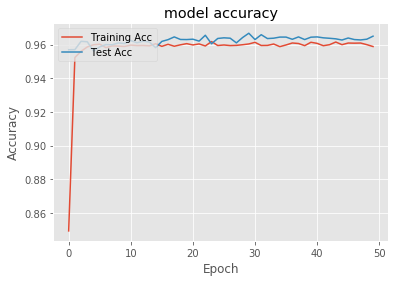

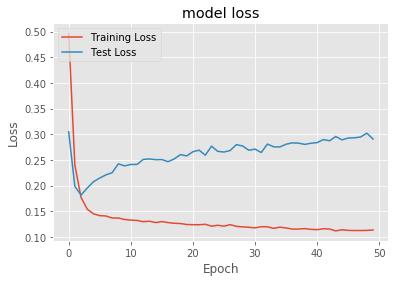

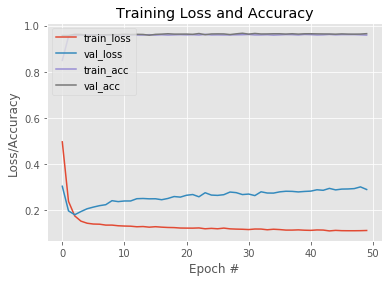

In [16]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [20]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.22334902301430704
Validation Accuracy:  0.97


In [32]:
random_seed = np.random.seed(333)

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 967 images belonging to 2 classes.


In [33]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

121/120 [==============================] - 15s 126ms/step
No of errors = 44/967


Confusion Matrix
[[641  14]
 [ 30 282]]


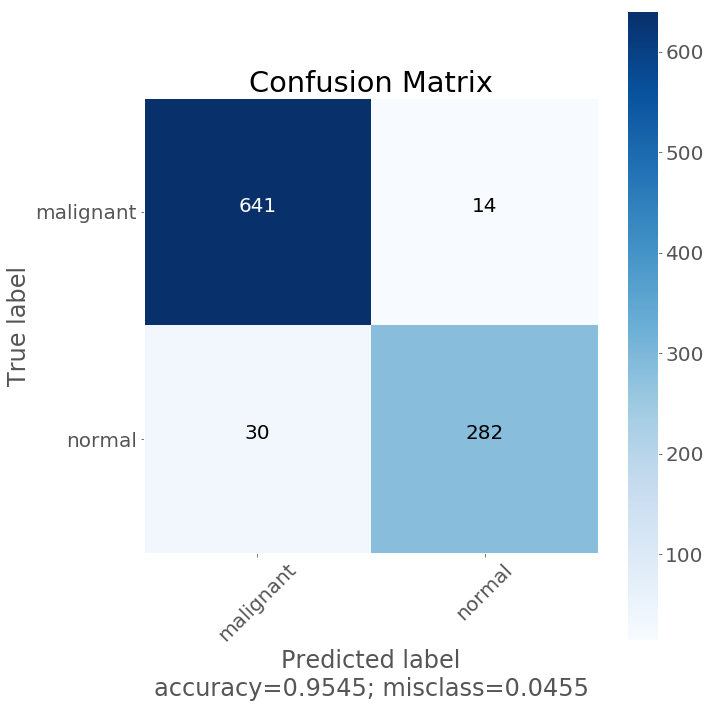

In [34]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/17.Ensemble-Models1-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,title='Confusion Matrix')

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[641  14]
 [ 30 282]]
             precision    recall  f1-score   support

  malignant       0.96      0.98      0.97       655
     normal       0.95      0.90      0.93       312

avg / total       0.95      0.95      0.95       967



In [36]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Accuracy :  0.954498448810755
Sensitivity :  0.9552906110283159
Specificity :  0.9527027027027027


In [37]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc))
print('Precision: {:.4f}'.format(prec))
print('Recall:    {:.4f}'.format(recall))
print('F1:        {:.4f}'.format(f1))

Accuracy:  0.9545
Precision: 0.9527
Recall:    0.9038
F1:        0.9276


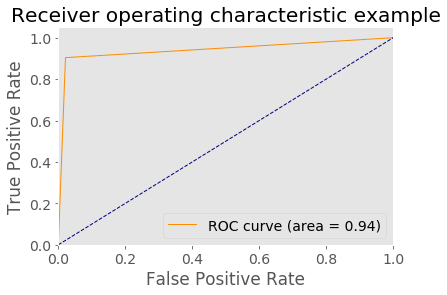

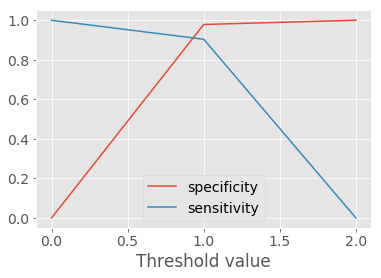

In [38]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()